## Background Removal with Robust PCA

#### Getting Started
        We'll use the real video dataset from the BMC 2012 background models challenge dataset

In [1]:
# importing some necessary libraries
import moviepy.editor as mpe
# from IPython.display import display
from glob import glob

In [2]:
import sys, os
import numpy as np
import scipy 
import matplotlib.pyplot as plt 
%matplotlib inline

In [3]:
TOL = 1.0e-8

In [4]:
# load the video
video = mpe.VideoFileClip("Video_003.avi")

In [5]:
video.subclip(0,50).ipython_display(width =300)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [6]:
# how long is the video
video.duration

113.57

### Making some Helper Functions

In [7]:
def create_data_matrix_from_video(clip, k=5, scale=50):
    return np.vstack([scipy.misc.imresize(rgb2gray(clip.get_frame(i/float(k))).astype(int), 
                      scale).flatten() for i in range(k * int(clip.duration))]).T


In [8]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])


In [9]:
def plt_images(M, A, E, index_array, dims, filename=None):
    f = plt.figure(figsize=(15, 10))
    r = len(index_array)
    pics = r * 3
    for k, i in enumerate(index_array):
        for j, mat in enumerate([M, A, E]):
            sp = f.add_subplot(r, 3, 3*k + j + 1)
            sp.axis('Off')
            pixels = mat[:,i]
            if isinstance(pixels, scipy.sparse.csr_matrix):
                pixels = pixels.todense()
            plt.imshow(np.reshape(pixels, dims), cmap='gray')
    return f

In [10]:
def plots(ims, dims, figsize=(15,20), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims)
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        plt.imshow(np.reshape(ims[i], dims), cmap="gray")

### Load and View the Data

        An image from 1 moment in time is 60 pixels by 80 pixels. We can unroll that picture into a single tall column. So instead ogf haing a 2D picture that is 60 * 80, we have a 1 * 4,800 column.

        This isn't very human readable, but its handy because it lets us stack the images from different times on top of one another, to put a video all into 1 matrix. If we took the video image every tenth of a second for 113 seconds, we'll have 11300 * 4800 matrix, representing the video

In [11]:
scale = 25   # Adjust scale to change resolution of image
dims = (int(240 * (scale/100)), int(320 * (scale/100)))

In [12]:
M = create_data_matrix_from_video(video, 100, scale)
# M = np.load("high_res_surveillance_matrix.npy")

In [13]:
print(dims, M.shape)

(60, 80) (4800, 11300)


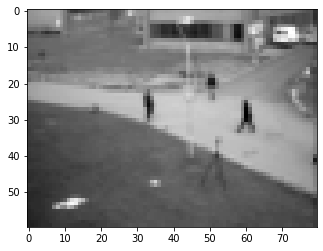

In [14]:
plt.imshow(np.reshape(M[:,140], dims), cmap='gray');

        Since create_data_from_matrix is somewhat slow, we will save our matrix. In general, whenever you have slow pre-processing steps, it's a good idea to save the results for future use.

In [15]:
np.save("low_res_surveillance_matrix.npy", M)

        Note: High-res M is too big to plot, so only run the below with the low-res version

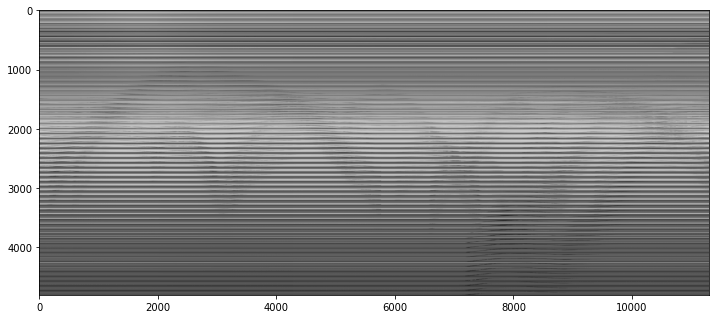

In [16]:
plt.figure(figsize=(12, 12))
plt.imshow(M, cmap='gray')

In [17]:
plt.imsave(fname="image1.jpg", arr=np.reshape(M[:,140], dims), cmap='gray')

## SVD

        A first attempt with SVD

In [18]:
from sklearn import decomposition

In [19]:
u, s, v = decomposition.randomized_svd(M,2)

In [20]:
u.shape, s.shape, v.shape

((4800, 2), (2,), (2, 11300))

In [21]:
low_rank = u @ np.diag(s) @ v

In [22]:
low_rank.shape

(4800, 11300)

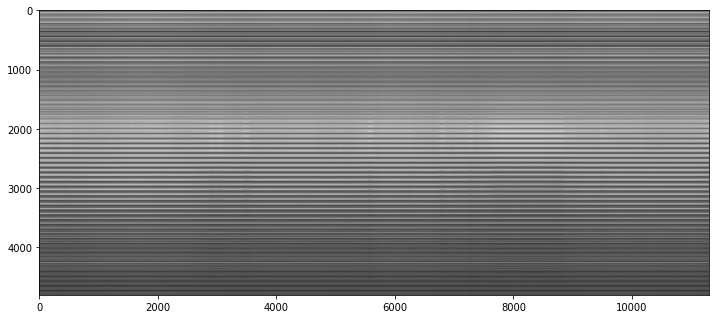

In [23]:
plt.figure(figsize=(12, 12))
plt.imshow(low_rank, cmap='gray')

        The below images were created with high-res data. Very slow to process:

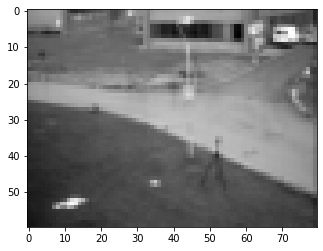

In [24]:
plt.imshow(np.reshape(low_rank[:,140], dims), cmap='gray');

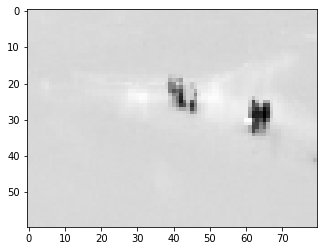

In [25]:
plt.imshow(np.reshape(M[:,550] - low_rank[:,550], dims), cmap='gray');

#### Rank 1 Approximation

In [26]:
u, s, v = decomposition.randomized_svd(M, 1)

In [27]:
u.shape, s.shape, v.shape

((4800, 1), (1,), (1, 11300))

In [28]:
low_rank = u @ np.diag(s) @ v

In [29]:
low_rank.shape

(4800, 11300)

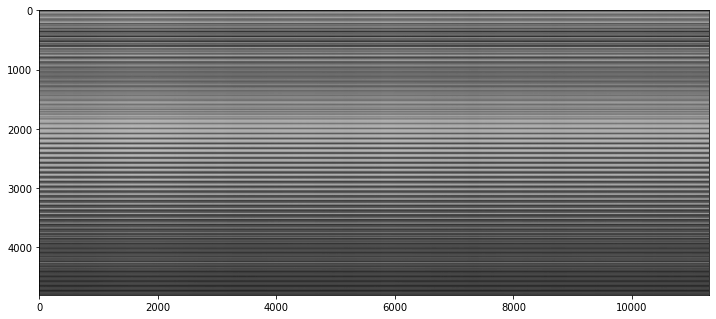

In [30]:
plt.figure(figsize=(12, 12))
plt.imshow(low_rank, cmap='gray')

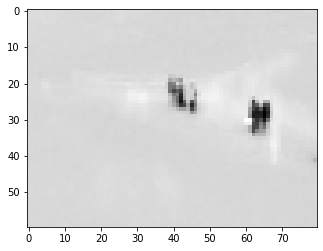

In [31]:
plt.imshow(np.reshape(M[:,550] - low_rank[:,550], dims), cmap='gray');

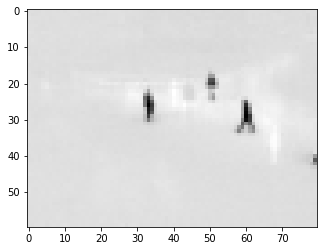

In [32]:
plt.imshow(np.reshape(M[:,140] - low_rank[:,140], dims), cmap='gray');

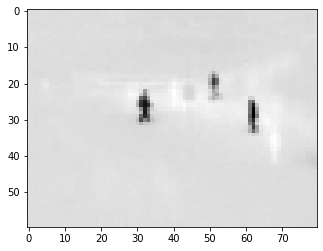

In [33]:
plt.imshow(np.reshape(M[:,100] - low_rank[:,100], dims), cmap='gray')

        Without the people

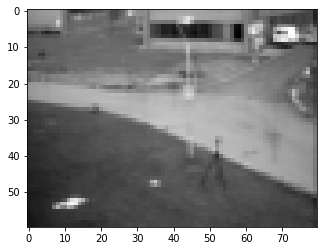

In [34]:
plt.imshow(np.reshape(low_rank[:,140], dims), cmap='gray')

### Principal Component Analysis (PCA)

    When dealing with high-dimensional data sets, we oftne leverage the fact that the data has low intrinsic dimensionality in order to alleviate the curse of dimensionality and scale.

    Principal Component Analysis is handy for eliminating dimensions. Classical PCA seeks the best rank-k estimate L of M. Truncated SVD makes this calculation.

    Traditional PCA can handle small noise, but is brittle with respect to grossly corrupted observations-- even one grossly corrupt observation can significantly mess up answer


    Robust PCA factors a matrix into the sum of two matrices, , where  is the original matrix,  is low-rank, and  is sparse. This is what we'll be using for the background removal problem! Low-rank means that the matrix has a lot of redundant information-- in this case, it's the background, which is the same in every scene (talk about redundant info!). Sparse means that the matrix has mostly zero entries-- in this case, see how the picture of the foreground (the people) is mostly empty. (In the case of corrupted data,  is capturing the corrupted entries)


#### L! norm indeces sparsity

    The unit ball ||x|| = 1 is a diamond in the L1 norm. It's extremas are the corners.

#### Optimization Problem
    Robust PCA can be written as:

$$ \text{minimize } ||L||_* + \lambda ||S||_1 \text{ subject to } L + S = M $$

    where
1.   $ ||.||_1 $  is the L1 norm. Minimizing the L1 norm results in sparse values. 

2.   $ ||.||_* $ is the nuclear norm, which is the L1 norm of the singular values

[Learn more about the theory](http://web.stanford.edu/~boyd/papers/cvx_short_course.html)

### Robust PCA

In [35]:
from scipy import sparse
from sklearn.utils.extmath import randomized_svd
import fbpca

In [36]:
TOL=1e-9
MAX_ITERS=3

In [37]:
def converged(Z, d_norm):
    err = np.linalg.norm(Z, 'fro') / d_norm
    print('error: ', err)
    return err < TOL

In [38]:
def shrink(M, tau):
    S = np.abs(M) - tau
    return np.sign(M) * np.where(S>0, S, 0)

In [39]:
def _svd(M, rank): return fbpca.pca(M, k=min(rank, np.min(M.shape)), raw=True)

In [40]:
def norm_op(M): return _svd(M, 1)[1][0]

In [41]:
def svd_reconstruct(M, rank, min_sv):
    u, s, v = _svd(M, rank)
    s -= min_sv
    nnz = (s > 0).sum()
    return u[:,:nnz] @ np.diag(s[:nnz]) @ v[:nnz], nnz

In [42]:
def pcp(X, maxiter=10, k=10): # refactored
    m, n = X.shape
    trans = m<n
    if trans: X = X.T; m, n = X.shape
        
    lamda = 1/np.sqrt(m)
    op_norm = norm_op(X)
    Y = np.copy(X) / max(op_norm, np.linalg.norm( X, np.inf) / lamda)
    mu = k*1.25/op_norm; mu_bar = mu * 1e7; rho = k * 1.5
    
    d_norm = np.linalg.norm(X, 'fro')
    L = np.zeros_like(X); sv = 1
    
    examples = []
    
    for i in range(maxiter):
        print("rank sv:", sv)
        X2 = X + Y/mu
        
        # update estimate of Sparse Matrix by "shrinking/truncating": original - low-rank
        S = shrink(X2 - L, lamda/mu)
        
        # update estimate of Low-rank Matrix by doing truncated SVD of rank sv & reconstructing.
        # count of singular values > 1/mu is returned as svp
        L, svp = svd_reconstruct(X2 - S, sv, 1/mu)
        
        # If svp < sv, you are already calculating enough singular values.
        # If not, add 20% (in this case 240) to sv
        sv = svp + (1 if svp < sv else round(0.05*n))
        
        # residual
        Z = X - L - S
        Y += mu*Z; mu *= rho
        
        examples.extend([S[140,:], L[140,:]])
        
        if m > mu_bar: m = mu_bar
        if converged(Z, d_norm): break
    
    if trans: L=L.T; S=S.T
    return L, S, examples

### Results

In [43]:
m, n = M.shape
round(m * .05)

240

In [44]:
L, S, examples =  pcp(M, maxiter=5, k=10)

rank sv: 1
error:  0.1316379371139472
rank sv: 241
error:  0.04585156886724389
rank sv: 49
error:  0.005891934918595679
rank sv: 289
error:  0.0005663084523533162
rank sv: 529
error:  2.479117952626825e-05


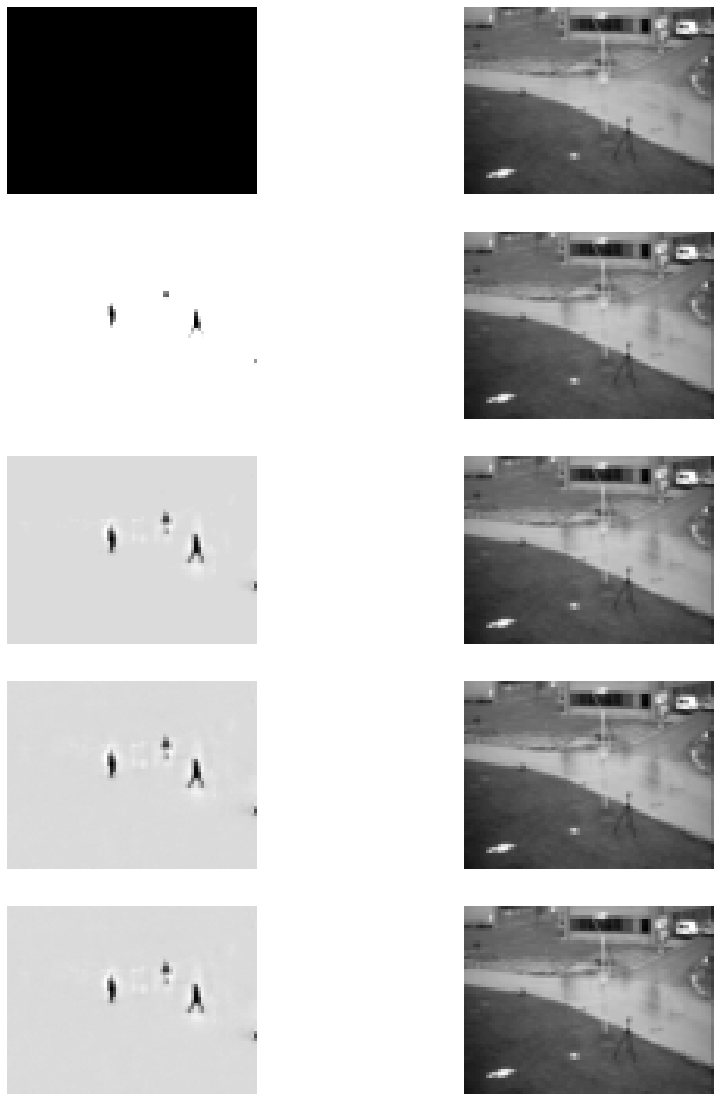

In [45]:
plots(examples, dims, rows=5)

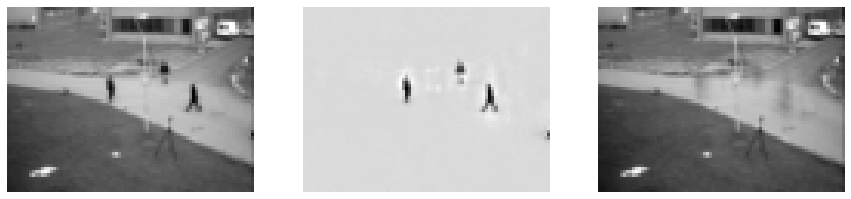

In [46]:
f = plt_images(M, S, L, [140], dims)

In [51]:
np.save("high_res_L.npy", L)
np.save("high_res_S.npy", S)

            Extracting a bit of foreground is easier than identifying the background. To accurately get the Background, you need to remove all the foreground, not just parts of it.

### LU Fcatorization

    Both fbpca and randomized_range_finder methods used LU factorization , which factors a matrix into the product of a lower triangular matrix and an upper triangular matrix.  

#### Gaussian Elimination

Watch this [video](https://www.khanacademy.org/math/precalculus/precalc-matrices/row-echelon-and-gaussian-elimination/v/matrices-reduced-row-echelon-form-2) for a beteter understanding


    It transforms a linear system into an upper triangular one by applying linear transformations on the left.

In [47]:
def LU(A):
    U = np.copy(A)
    m, n = A.shape
    L = np.eye(n)
    for k in range(n-1):
        for j in range(k+1,n):
            L[j,k] = U[j,k]/U[k,k]
            U[j,k:n] -= L[j,k] * U[k,k:n]
    return L, U

In [48]:
A = np.array([[2,1,1,0],[4,3,3,1],[8,7,9,5],[6,7,9,8]]).astype(np.float)

In [49]:
L, U = LU(A)

In [50]:
np.allclose(A, L @ U)

True

    The  LU factorization is useful!
    Solving Ax = b becomes LUx = b
    1. find A = LU
    2. solve Ly = b
    3. solve Ux = y  

